[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Dev-Khant/Image-Captioning-/blob/main/image-captioning.ipynb)

## Import Libraries

In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
import re
import nltk
import pickle
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction 
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.layers import Input, Dense, Embedding, GRU, Concatenate, Reshape
from tensorflow.keras import Model, Sequential

## Define Constants

In [2]:
# Constants
AUTOTUNE = tf.data.experimental.AUTOTUNE 
vocab_size = 5000
sequence_length = 25
embedding_dim = 256
units = 512
batch_size = 64
epochs = 25
img_size = 224
channels = 3

# Directories
images = "flickr-image-dataset/flickr30k_images/flickr30k_images/"
captions = "flickr-image-dataset/flickr30k_images/results.csv"

## Read Dataset

In [3]:
# Read dataset, Rename columns, Drop null rows, Convert data type of comment_id
cap_df = pd.read_csv(captions, delimiter = "|")
cap_df.rename(columns = {"image_name" : "image_id", " comment_number" : "comment_id", " comment" : "comment"}, inplace = True)
cap_df.dropna(axis = 0, inplace = True)
cap_df["comment_id"] = cap_df["comment_id"].astype("int32")
cap_df.sample(5)

,image_id,comment_id,comment
57108,3131359135.jpg,3,"A man is walking down a street , holding a br..."
95501,4294390957.jpg,1,Man in suits stands at podium and speaks .
52609,3021449235.jpg,4,A female child is playing with three cubes .
78480,360651988.jpg,0,A well dressed asian businessman walking ahea...
85613,3806961324.jpg,3,Man in front of a large glass building .


In [4]:
# Take only one caption for every image
df = cap_df[cap_df["comment_id"] == 0]
df = pd.DataFrame(df)
df.sample(5)

,image_id,comment_id,comment
8510,1472249944.jpg,0,A woman in an orange coat and jeans is squatt...
124330,4898640485.jpg,0,A woman with red dyed hair standing and walki...
24415,2315113960.jpg,0,A museum guide showing a person places on the...
36985,2622581408.jpg,0,Four teenagers dressed in black and white shi...
9645,1546632452.jpg,0,A little boy wearing a long-sleeve t-shirt an...


 Two young guys with shaggy hair look at their hands while hanging out in the yard . 



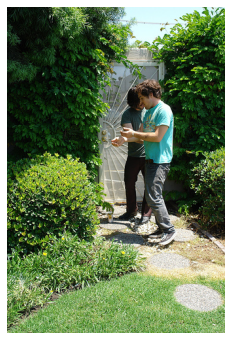

In [5]:
# Show image
plt.figure(figsize = (6,6))
img = plt.imread("flickr-image-dataset/flickr30k_images/flickr30k_images/1000092795.jpg")
plt.axis("off")
plt.imshow(img)
print(df["comment"].iloc[0],"\n")

## Clean Text

In [6]:
# Clean Text
lemmatizer = WordNetLemmatizer()
def clean_text(sent):
    sent = sent.lower()
    sent = re.sub("[0-9]","",sent)     # digits
    sent = re.sub("https?://\S+","",sent)     # URLs
    sent = re.sub("@\S+","",sent)     # @'s
    sent = re.sub("[+-/*,':%$#&!_<>(){}^]","",sent)     # special characters  
    sent = re.sub(" +"," ",sent)     # extra spaces
    words = nltk.word_tokenize(sent)
    stop_words = set(nltk.corpus.stopwords.words("english"))
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    sent = ' '.join(words)
    sent = "[start] " + sent + " [end]"
    return sent


df["comment"] = df["comment"].apply(lambda x: clean_text(x))

In [7]:
# Create Sentence Vectorizer
sent_vectorization = TextVectorization(
    max_tokens = vocab_size, output_mode = "int", output_sequence_length = sequence_length
)
sent_vectorization.adapt(df["comment"].values)

# Index to Word mapping
index_to_word = dict()
for index, word in enumerate(sent_vectorization.get_vocabulary()):
    index_to_word[index] = word

2022-01-05 12:35:30.478609: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-05 12:35:30.578878: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-05 12:35:30.580059: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-05 12:35:30.581652: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

## Define Dataset

In [8]:
# Define Dataset Function
def image_read(path):
    path = "flickr-image-dataset/flickr30k_images/flickr30k_images/" + path
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels = channels)
    img = tf.cast(img, tf.float32)
    img = tf.image.resize(img, (img_size, img_size))
    img = tf.keras.applications.efficientnet.preprocess_input(img)
    return img

def process_text(sentences):
    caption_vector = sent_vectorization(sentences)
    return caption_vector

def create_dataset(images, texts, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((images, texts))
    dataset = dataset.map(lambda a, b : (image_read(a), process_text(b)), num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [9]:
# Create Dataset
df = df.sample(frac = 1)
trn = df[:30783]
test = df[30783:]

train = create_dataset(trn["image_id"].values, trn["comment"].values, batch_size)

## Define Model

In [10]:
# EfficientNet for image context
base_model = EfficientNetB0(input_shape = (img_size, img_size, 3), include_top=False, weights="imagenet")
base_model.trainable = False
base_model_out = base_model.output
base_model_out = tf.keras.layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out)
cnn_model = Model(base_model.input, base_model_out)

# CNN_encoder for fine tuning
class CNN_encoder(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(CNN_encoder, self).__init__()
        self.dense = Dense(embedding_dim, activation = "relu")
        
    def call(self, img_context):
        x = self.dense(img_context)
        return x

16719872/16705208 [==============================] - 0s 0us/step


In [11]:
# Attention Class
class Attention(tf.keras.Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.units = units
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.S = Dense(1)
    
    def call(self, features, hidden):
        hidden_state_with_time_axis = tf.expand_dims(hidden, 1)
        
        attention_hidden_layer = tf.nn.tanh(self.W1(features) + 
                                            self.W2(hidden_state_with_time_axis))
        
        score = self.S(attention_hidden_layer)
        attention_weights = tf.nn.softmax(score, axis = 1)
        
        context_vector = features * attention_weights
        context_vector = tf.reduce_sum(context_vector, axis = 1)
        return context_vector

In [12]:
# RNN_encoder for sentence creation
class RNN_decoder(tf.keras.Model):
    def __init__(self, embedding_size, vocab_size, units):
        super(RNN_decoder, self).__init__()
        self.units = units
        self.attention = Attention(units)
        self.embedding = Embedding(vocab_size, embedding_size)
        self.gru = GRU(units, 
                       return_sequences = True, 
                       return_state = True)
        self.dense1 = Dense(units)
        self.dense2 = Dense(vocab_size)
    
    def call(self, x, features, hidden_state):
        context_vector = self.attention(features, hidden_state)
        x = self.embedding(x)
        x = tf.concat([x, tf.expand_dims(context_vector, 1)], axis = -1)
        x, states = self.gru(x)
        x = self.dense1(x)
        x = tf.reshape(x, (-1, x.shape[2]))
        x = self.dense2(x)
        return x, states

## Train Model


In [13]:
encoder = CNN_encoder(embedding_dim)
decoder = RNN_decoder(embedding_dim, vocab_size, units)

optimizer = tf.keras.optimizers.Adam()
loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)

# Custom loss function 
# Ignores the prediction of [mask] values
def loss_fn(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    final_loss = loss_obj(real, pred)
    
    mask = tf.cast(mask, dtype = final_loss.dtype)
    final_loss *= mask
    
    return tf.reduce_sum(final_loss)

In [14]:
# For each Batch
def train_step(img_tensor, target):
    loss = 0
    dec_input = tf.expand_dims([int(sent_vectorization('[start]')[0])] * target.shape[0], 1)
    hidden_state = tf.zeros((batch_size, units))
    
    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        
        for i in range(1, target.shape[1]):
            pred, hidden_state = decoder(dec_input, features, hidden_state)
            loss += loss_fn(target[:, i], pred)
            
            dec_input = tf.expand_dims(target[:, i], 1)
        
    total_loss = loss / int(target.shape[1])
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    grads = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(grads, trainable_variables))

    return total_loss

In [15]:
# Train model
for epoch in range(epochs):
    total_loss = 0
    
    for imgs, target in train:
        img_tensor = cnn_model(imgs)
        loss = train_step(img_tensor, target)
        total_loss += loss
    
    print("##### Epoch {} #####".format(epoch + 1))
    print("Loss is {}".format(total_loss / len(trn)),"\n")

2022-01-05 12:35:40.877085: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


##### Epoch 1 #####
Loss is 2.0868775844573975 

##### Epoch 2 #####
Loss is 1.7684135437011719 

##### Epoch 3 #####
Loss is 1.6489759683609009 

##### Epoch 4 #####
Loss is 1.5578467845916748 

##### Epoch 5 #####
Loss is 1.4774494171142578 

##### Epoch 6 #####
Loss is 1.3996301889419556 

##### Epoch 7 #####
Loss is 1.3254116773605347 

##### Epoch 8 #####
Loss is 1.250556230545044 

##### Epoch 9 #####
Loss is 1.1785277128219604 

##### Epoch 10 #####
Loss is 1.1267772912979126 

##### Epoch 11 #####
Loss is 1.0527913570404053 

##### Epoch 12 #####
Loss is 0.9876796007156372 

##### Epoch 13 #####
Loss is 0.9409835338592529 

##### Epoch 14 #####
Loss is 0.9016639590263367 

##### Epoch 15 #####
Loss is 0.8512966632843018 

##### Epoch 16 #####
Loss is 0.7996532917022705 

##### Epoch 17 #####
Loss is 0.7479760646820068 

##### Epoch 18 #####
Loss is 0.7120420932769775 

##### Epoch 19 #####
Loss is 0.687501072883606 

##### Epoch 20 #####
Loss is 0.6600478887557983 

##### Epoch

In [16]:
# Save weights of Model and Vectorizer
encoder.save_weights("encoder_weights.h5")
decoder.save_weights("decoder_weights.h5")

pickle.dump({'config': sent_vectorization.get_config(),
             'weights': sent_vectorization.get_weights()}, 
             open("sent_vectorizer.pkl", "wb"))

## Evaluate Model

In [17]:
# Caption function for evaluation
def caption(path):
    img = image_read(path)
    img = tf.expand_dims(img, 0)
    context = cnn_model(img)
    features = encoder(context)
    
    dec_input = tf.expand_dims([int(sent_vectorization('[start]')[0])], 0)
    hidden_state = tf.zeros((1, units))
    sentence = []
    for i in range(20):
        pred, hidden_state = decoder(dec_input, features, hidden_state)
        predicted_id = np.argmax(tf.reshape(pred,-1))
        predicted_word = index_to_word[predicted_id]
        sentence.append(predicted_word)
    
        if predicted_word == "end":
            return ' '.join(sentence[:-1])
        
        dec_input = tf.expand_dims([predicted_id], 0)
    return ' '.join(sentence)

group young people standing around [UNK] [UNK] 



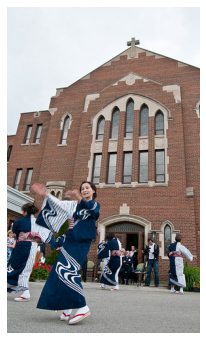

In [18]:
# Show image
plt.figure(figsize = (6,6))
img = plt.imread("flickr-image-dataset/flickr30k_images/flickr30k_images/" + test["image_id"].iloc[5])
plt.axis("off")
plt.imshow(img)
pred = caption(test["image_id"].iloc[0])
print(pred,"\n")

In [19]:
# Bleu score function
def BLEU_score(real, pred):
    x = real.split()
    y = pred.split()
    
    smooth = SmoothingFunction().method4
    bleu = sentence_bleu([x[1:-1]], y, smoothing_function = smooth)
    return bleu

In [20]:
# Evaluate on Test Data
# BLEU score the Higher the Better
bleu = 0
for i in range(test.shape[0]):
    test_img = test["image_id"].iloc[0]
    test_target = test["comment"].iloc[0]
    prediction = caption(test_img)
    bleu += BLEU_score(test_target, prediction)

print("BLEU score is {}".format(bleu / test.shape[0]))

BLEU score is 0.12972593961619314
